# Clustering Lyrical Data

Notebook Shortcuts:
1. [Introduction and Limitations](https://github.com/philbowman212/Thinkful_repo/blob/master/projects/unsupervised_capstone/1_Introduction_and_Limitations.ipynb)
2. [Exploration](https://github.com/philbowman212/Thinkful_repo/blob/master/projects/unsupervised_capstone/2_Exploration.ipynb)
3. [Cleaning Lyrics](https://github.com/philbowman212/Thinkful_repo/blob/master/projects/unsupervised_capstone/3_Cleaning_Lyrics.ipynb) (you are here)
4. [Topic Modeling](https://github.com/philbowman212/Thinkful_repo/blob/master/projects/unsupervised_capstone/4_Topic_Modeling.ipynb)
5. [More Topic Modeling and Clustering](https://github.com/philbowman212/Thinkful_repo/blob/master/projects/unsupervised_capstone/5_More_Topic_Modeling_and_Clustering.ipynb)
6. [Conclusion and Wordclouds](https://github.com/philbowman212/Thinkful_repo/blob/master/projects/unsupervised_capstone/6_Conclusion_and_Wordclouds.ipynb)

# 3: Cleaning Lyrics

When it comes to getting good results for any model, **cleaning is *THE KEY* step**. The ubiquitous adage, "garbage in, garbage out", absolutely applies here. It just so happens that this is also perhaps the most difficult step of the entire project.

The reason it is so difficult is because it requires many iterations, many judgement calls and some subjectivity. In this particular case, the way the lyrics are cleaned is completely dependent on the content of the corpus and the format required by the models. And even then, it's possible it won't be done "right". In fact it's essentially impossible to clean this data perfectly. But, what matters is that it generates meaningful results.

This will be an extremely iterative process and will likely require returning to this notebook over and over again to make tweaks and changes here and there. The goal is to get the lyrics into a format that is useful for topic modeling, particularly for Gensim's LDA, LSI, and NMF implementations.

With all that being said, time to jump in the deep end.

In [222]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import string
import regex as re
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
import spacy
%matplotlib inline

In [2]:
%%capture
from tqdm import tqdm
try:
    tqdm._instances.clear()
    tqdm.pandas()
except:
    tqdm.pandas()

## 3.1: Sample the data

In order to speed things up a little bit (many operations take an eternity on such a big data set and some have trouble fitting in my local machine's memory), I'm going to limit the sample to about 64% of the original data.

In [98]:
data = pd.read_pickle(r'C:\Users\philb\Repos\Thinkful_repo\projects\unsupervised_capstone\pickle\data\scoped_data.pkl').lyrics

In [99]:
base, holdout = train_test_split(data, test_size=.2, random_state=345)
train, test = train_test_split(base, test_size=.2, random_state=2345)

In [100]:
train.shape[0] / data.shape[0], test.shape[0] / data.shape[0], holdout.shape[0] / data.shape[0]

(0.6399956247094534, 0.16000437529054665, 0.2)

With the data split into 3 groups (64% "train", 16% "test", and 20% "holdout"), export these to pickle files for future use.

In [101]:
train.to_pickle(r'C:\Users\philb\Repos\Thinkful_repo\projects\unsupervised_capstone\pickle\data\train.pkl')
test.to_pickle(r'C:\Users\philb\Repos\Thinkful_repo\projects\unsupervised_capstone\pickle\data\test.pkl')
holdout.to_pickle(r'C:\Users\philb\Repos\Thinkful_repo\projects\unsupervised_capstone\pickle\data\holdout.pkl')

## 3.2: Clean, clean, clean

In [59]:
def clean_text(text):
    text = re.sub(r'\[.*\]', ' ', text) #gets rid of any brackets ('[' and ']') as well as any text within the brackets
    text = re.sub(r'\(.*?\d+.*?\)', ' ', text) #gets rid of any parenthesis with numbers inside (generally indicates repetition of section)
    text = re.sub(r'.*\bverse\b.*', ' ', text, flags=re.IGNORECASE) #gets rid of any lines containing the word "verse" exactly case independent
    text = re.sub(r'.*instrumental.*', ' ', text, flags=re.IGNORECASE) #mass majority of "instrumental" occurring in lyrics is an indicator for an instrumental section
    text = re.sub(r'.*chorus.*', ' ', text, flags=re.IGNORECASE) #mass majority of "chorus" occurring in lyrics is an indicator for where a chorus appears
    text = re.sub(r'.*\bbridge\b.*', ' ', text, flags=re.IGNORECASE) #majority of "bridge" exact are indicators for the bridge section of a song
    text = re.sub(r'\w+:', ' ', text) #get rid of any leading artists using a colon
    text = re.sub(r'\w*\d+\w*', ' ', text) #get rid of any strings containing numbers
    text = ''.join([char for char in text if char not in string.punctuation]) #get rid of all punctuation
    text = text.lower() #converts to lowercase
    text = ' '.join(text.split()) #clean up any whitespace
    text = re.sub(r'\w*[^a-z ]+\w*', ' ', text) #gets rid of any non-alpha or non-space characters or words containing them
    text = re.sub(r'([a-z])\1\1+', r'\1', text) #fixes any cases where a character is repeated 3 times or more (i.e. yeeeeeah --> yeah)
    text = ' '.join(text.split()) #clean up any whitespace again
    return text

In [60]:
clean_train = train.progress_apply(clean_text)

100%|█████████████████████████████████████████████████████████████████████████| 117020/117020 [02:59<00:00, 652.49it/s]


After digging into a bunch of regular expressions, the above function seems to end up with relatively good results, and works relatively quickly even over 100,000+ songs. There are definitely improvements that can be made, but this cleaning process will never be perfect. The question is, will there be good results?

In [202]:
def new_orig(series):
    series_df = series.reset_index()
    random_idx = np.random.randint(series_df.shape[0])
    series_text = series_df.iloc[random_idx]['lyrics']
    real_idx = series_df.iloc[random_idx]['index']
    orig_song_text = train[real_idx]
    print(f'Song ID: {real_idx}')
    print('---------------')
    print('Cleaned Version')
    print('---------------')
    print(series_text)
    print('----------------')
    print('Original Version')
    print('----------------')
    print(orig_song_text)

In [205]:
new_orig(clean_train)

Song ID: 285206
---------------
Cleaned Version
---------------
if you follow the jawline down over the heart the curves of your bone and muscle that make up your head to toeits just skin and thread stitches and ligaments words that we spoke only to regret i know theyre going to laugh at us when they see us out together holding hands like this they wouldnt understand it if we told them all the reasons not that i think this deserves any kind of explanation we can make it up so weve got a smile painted on all the time no matter what its like on the inside well keep this keep us like a secret because if my family and friends ever found out about the things we could never be haunts well always keep so fucking bittersweet
----------------
Original Version
----------------
If you follow the jaw-line down over the heart, the curves of your bone and muscle that make up your head to toe...it's just skin and thread, stitches and ligaments, words that we spoke only to regret. I know they're going

Store the cleaned lyrics as well as the function that cleaned the text to be used on test and holdout data later on.

In [93]:
clean_train.to_pickle(r'C:\Users\philb\Repos\Thinkful_repo\projects\unsupervised_capstone\pickle\data\clean_train.pkl')

In [103]:
outfile = open(r'C:\Users\philb\Repos\Thinkful_repo\projects\unsupervised_capstone\pickle\functions\clean_text.pkl', 'wb')
pickle.dump(clean_text, outfile)
outfile.close()

## 3.3: Reinspection

In [75]:
huge_string = ' '.join(clean_train)

In [76]:
huge_list = huge_string.split()

In [78]:
word_count = Counter(huge_list)

In [171]:
word_count_df = pd.DataFrame(word_count.items(), columns=['term', 'counts']).sort_values('counts', ascending=False)

In [172]:
word_count_df.counts.sum(), word_count_df.shape[0]

(24931005, 156349)

After cleaning, there's nearly 25 million total occurrences of terms through the training set's songs. The total number of unique terms at this point sits a little above 150,000 terms.

In [173]:
word_count_df.describe()

,counts
count,156349.000000
mean,159.457400
std,5616.148653
min,1.000000
25%,1.000000
50%,2.000000
75%,6.000000
max,997663.000000


The average number of times a term appears appears to be aorund 160 times, but compared to the median of 2, it's easy to see that some words appear extremely frequently, skewing the mean very high.

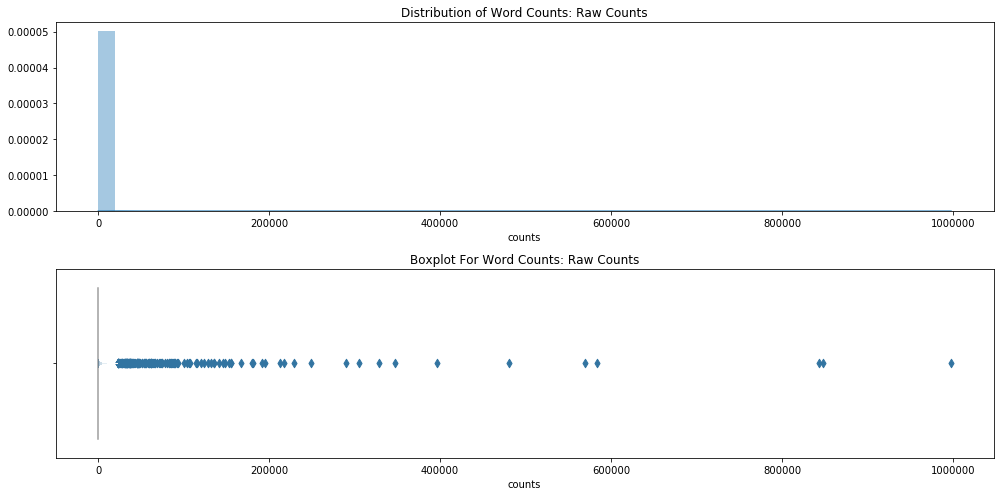

In [174]:
plt.figure(figsize=(14,7))

plt.subplot(211)
sns.distplot(word_count_df.counts)
plt.title('Distribution of Word Counts: Raw Counts')

plt.subplot(212)
sns.boxenplot(word_count_df.counts)
plt.title('Boxplot For Word Counts: Raw Counts')

plt.tight_layout()
plt.show()

In [175]:
word_count_df['word_share_pct'] = word_count_df.counts / word_count_df.counts.sum() * 100

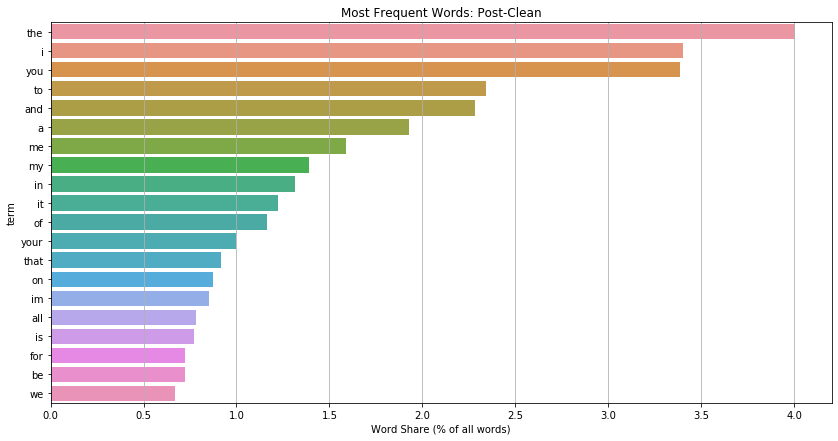

Top 20 Words - Word Share Total: 31.33%


In [181]:
plt.figure(figsize=(14,7))
sns.barplot(x='word_share_pct', y='term', data=word_count_df.sort_values('word_share_pct', ascending=False).iloc[:20])
plt.title('Most Frequent Words: Post-Clean')
plt.xlabel('Word Share (% of all words)')
plt.grid(axis='x')
plt.show()

print(f'Top 20 Words - Word Share Total: {round(word_count_df.word_share_pct.iloc[:20].sum(), 2)}%')

The top 20 most frequent words account for over 30% of the total words in the corpus!

In [196]:
top_1_percent = int(word_count_df.shape[0] * .01)
print(f'The top 1% most frequent words ({top_1_percent} words) account for {round(word_count_df.word_share_pct.iloc[:top_1_percent].sum(), 2)}% of all the words!')
top_10_percent = int(word_count_df.shape[0] * .1)
print(f'The top 10% most frequent words ({top_10_percent} words) account for {round(word_count_df.word_share_pct.iloc[:top_10_percent].sum(), 2)}% of all the words!')

The top 1% most frequent words (1563 words) account for 88.64% of all the words!
The top 10% most frequent words (15634 words) account for 98.04% of all the words!


There is an extreme lack of parity when it comes to the distribution of words in this corpus, this is, of course, why stop words exist.

## 3.4: Stop words

Alright, when it comes to stop words, using NLTK and Scikit-learn's base sets (along with their non-single quote brethren) should take care of a decent chunk. These have already been pickled in the prior notebook.

In [197]:
infile = open(r'C:\Users\philb\Repos\Thinkful_repo\projects\unsupervised_capstone\pickle\stopwords\base_stopwords.pkl', 'rb')
base_stopwords = pickle.load(infile)
infile.close()

In [200]:
base_stop_removed_clean_train = clean_train.progress_apply(lambda x: ' '.join([w for w in x.split() if w not in base_stopwords]))

100%|███████████████████████████████████████████████████████████████████████| 117020/117020 [00:07<00:00, 15372.46it/s]


In [207]:
new_orig(base_stop_removed_clean_train)

Song ID: 20271
---------------
Cleaned Version
---------------
wake wake wake eyes open wide wake panting say dreams deeper meaning cries subconscious feel strangely compelled recount love annabel shaking gently wonder flesh chill virgin snow thoughts disrupted reality hits like bold lightning scream crucified virtuous damned crucified nightmare lets pray fall asleep imprisoned beneath world soulless dwell lies place damned home place virtuous hide fear place nightmares place sun silent
----------------
Original Version
----------------
Wake up, wake up, wake up
My eyes open wide as I wake, panting,
Some say that dreams have deeper meaning.
That they are cries from our subconscious.
I feel strangely compelled to recount this one to my love,
My Annabel, shaking her gently,
I wonder why her flesh has the chill of virgin snow.
My thoughts are disrupted as reality hits me like a bold of lightning and I scream.
We are the crucified, we are the virtuous, we are the damned.
We are the crucifi

In [221]:
def inspect(series):
    huge_string = ' '.join(series)
    huge_list = huge_string.split()
    word_count = Counter(huge_list)
    word_count_df = pd.DataFrame(word_count.items(), columns=['term', 'counts']).sort_values('counts', ascending=False)
    word_count_df['word_share_pct'] = word_count_df.counts / word_count_df.counts.sum() * 100
    print('----------------------------------------')
    print(f'Word Count: {word_count_df.counts.sum()}')
    print(f'Total Terms: {word_count_df.shape[0]}')
    print('----------------------------------------')
    print('----------------------------------------')
    print(word_count_df.describe())
    print('----------------------------------------')
    print('----------------------------------------')
    print(f'Top 20 Words - Word Share Total: {round(word_count_df.word_share_pct.iloc[:20].sum(), 2)}%')
    print('----------------------------------------')
    top_1_percent = int(word_count_df.shape[0] * .01)
    print(f'- The top 1% most frequent words ({top_1_percent} words) account for {round(word_count_df.word_share_pct.iloc[:top_1_percent].sum(), 2)}% of all the words!')
    top_10_percent = int(word_count_df.shape[0] * .1)
    print(f'- The top 10% most frequent words ({top_10_percent} words) account for {round(word_count_df.word_share_pct.iloc[:top_10_percent].sum(), 2)}% of all the words!')
    print('----------------------------------------')    
    #plot #1
    plt.figure(figsize=(14,7))
    plt.subplot(211)
    sns.distplot(word_count_df.counts)
    plt.title('Distribution of Word Counts: Raw Counts')
    plt.subplot(212)
    sns.boxenplot(word_count_df.counts)
    plt.title('Boxplot For Word Counts: Raw Counts')
    plt.tight_layout()
    plt.show()
    
    #plot #2
    plt.figure(figsize=(14,7))
    sns.barplot(x='word_share_pct', y='term', data=word_count_df.sort_values('word_share_pct', ascending=False).iloc[:20])
    plt.title('Most Frequent Words')
    plt.xlabel('Word Share (% of all words)')
    plt.grid(axis='x')
    plt.tight_layout()
    plt.show()

----------------------------------------
Word Count: 10843433
Total Terms: 155980
----------------------------------------
----------------------------------------
              counts  word_share_pct
count  155980.000000   155980.000000
mean       69.518098        0.000641
std      1305.712876        0.012042
min         1.000000        0.000009
25%         1.000000        0.000009
50%         2.000000        0.000018
75%         5.000000        0.000046
max    212863.000000        1.963059
----------------------------------------
----------------------------------------
Top 20 Words - Word Share Total: 15.88%
----------------------------------------
- The top 1% most frequent words (1559 words) account for 76.59% of all the words!
- The top 10% most frequent words (15598 words) account for 95.58% of all the words!
----------------------------------------


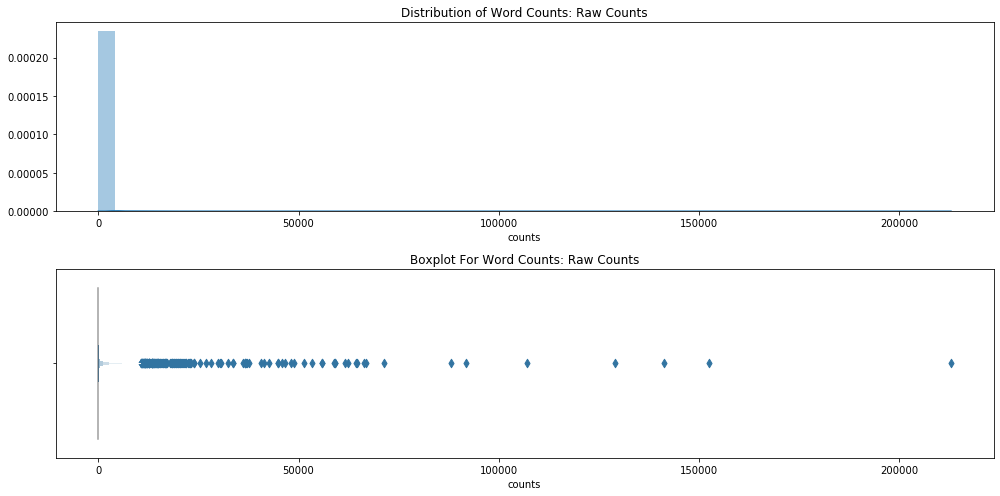

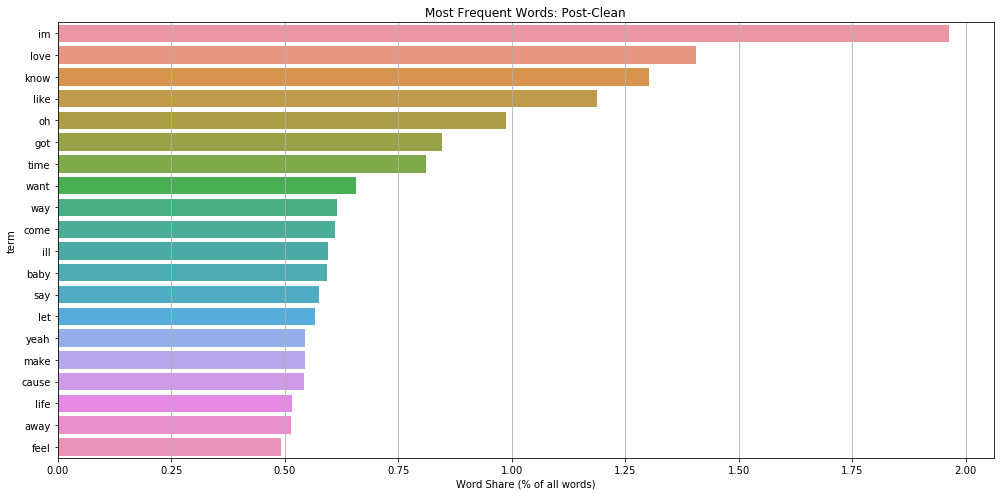

In [219]:
inspect(base_stop_removed_clean_train)

In [229]:
base_stop_removed_clean_train.to_pickle(r'C:\Users\philb\Repos\Thinkful_repo\projects\unsupervised_capstone\pickle\data\base_stop_removed_clean_train.pkl')

Definitely looks like the stop word list can be improved upon further. A lot of these words don't have much in terms of meaning. What if the words included were limited to only nouns? Better yet, what if only the lemmas (base form) were included?

## 3.5: Lemmatizing and limiting parts of speech

In [225]:
nlp = spacy.load('en_core_web_md', disable=['parser', 'ner'])

In [226]:
def lemmatize_pos(text, allowed_postags=['NOUN']):
    doc = nlp(text)
    lemmas = [token.lemma_ for token in doc if token.pos_ in allowed_postags]
    text = ' '.join(lemmas)
    return text

In [227]:
lemma_base_stop_removed_clean_train = base_stop_removed_clean_train.progress_apply(lambda x: lemmatize_pos(x))

100%|██████████████████████████████████████████████████████████████████████████| 117020/117020 [37:24<00:00, 52.14it/s]


----------------------------------------
Word Count: 3978408
Total Terms: 32953
----------------------------------------
----------------------------------------
              counts  word_share_pct
count   32953.000000    32953.000000
mean      120.729767        0.003035
std      1462.255759        0.036755
min         1.000000        0.000025
25%         1.000000        0.000025
50%         3.000000        0.000075
75%        14.000000        0.000352
max    132993.000000        3.342870
----------------------------------------
----------------------------------------
Top 20 Words - Word Share Total: 23.56%
----------------------------------------
- The top 1% most frequent words (329 words) account for 63.48% of all the words!
- The top 10% most frequent words (3295 words) account for 93.72% of all the words!
----------------------------------------


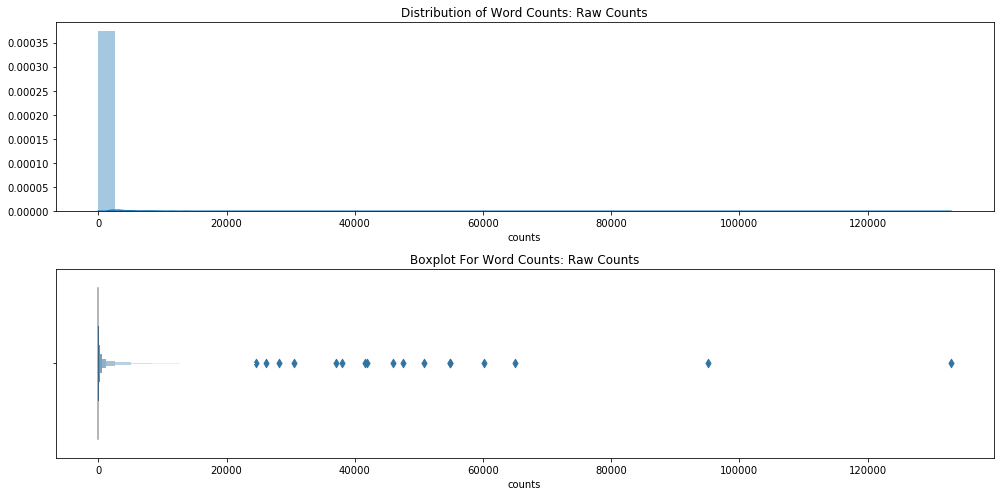

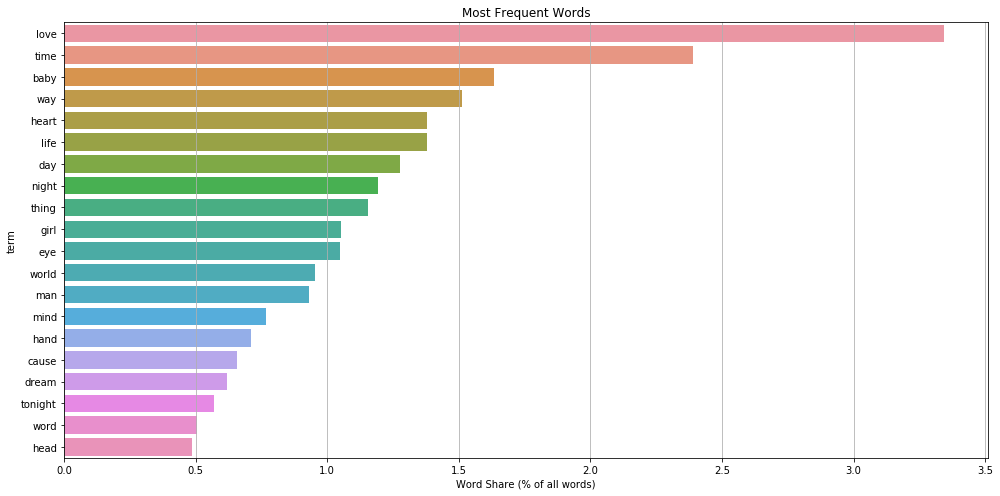

In [228]:
inspect(lemma_base_stop_removed_clean_train)

In [230]:
lemma_base_stop_removed_clean_train.to_pickle(r'C:\Users\philb\Repos\Thinkful_repo\projects\unsupervised_capstone\pickle\data\lemma_base_stop_removed_clean_train.pkl')

Limiting terms to the lemma form and including only nouns brought the total amount of words down significantly. Now that there are some different pickled datasets to use, on to modeling.

## Shortcuts

Notebook Shortcuts:
1. [Introduction and Limitations](https://github.com/philbowman212/Thinkful_repo/blob/master/projects/unsupervised_capstone/1_Introduction_and_Limitations.ipynb)
2. [Exploration](https://github.com/philbowman212/Thinkful_repo/blob/master/projects/unsupervised_capstone/2_Exploration.ipynb)
3. [Cleaning Lyrics](https://github.com/philbowman212/Thinkful_repo/blob/master/projects/unsupervised_capstone/3_Cleaning_Lyrics.ipynb) (you are here)
4. [Topic Modeling](https://github.com/philbowman212/Thinkful_repo/blob/master/projects/unsupervised_capstone/4_Topic_Modeling.ipynb)
5. [More Topic Modeling and Clustering](https://github.com/philbowman212/Thinkful_repo/blob/master/projects/unsupervised_capstone/5_More_Topic_Modeling_and_Clustering.ipynb)
6. [Conclusion and Wordclouds](https://github.com/philbowman212/Thinkful_repo/blob/master/projects/unsupervised_capstone/6_Conclusion_and_Wordclouds.ipynb)